# Set up

In [321]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#%pip install -U multiprocess
#!conda update conda -y

In [322]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [323]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True
reload_modules       = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.04 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 11 # values larger than 10 take considerably longer to complete
min_doc_size         =  5

## preprocessing settings
lower_chars          = True
strip_accents        = False
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes longer to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
print(f"inclusion_degree: {inclusion_degree}")

max_gap_size_factor   = 0.53 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.
print(f"max_gap_size: {max_gap_size}")

## Skippy n-gram の隙間を表わす記号
gap_mark            = "…"

## spell term と sound term の連結記号
pair_mark           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[3]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[4]
print(f"sn_term_type: {sn_term_type}")

## n_for_ngram
n_sp = sp_term_type.split("gram")[0][-1]
n_sn = sn_term_type.split("gram")[0][-1]
n_for_ngram = max(int(n_sp), int(n_sn))
print(f"n_for_ngram: {n_for_ngram}")

inclusion_degree: 1
max_gap_size: 6
sp_term_type: sp_4gram
sn_term_type: sn_5gram
n_for_ngram: 5


In [324]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 2 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [325]:
## select HDP or LDA: HDP takes considerably longer to complete than LDA with large n_topics,
## HDP
use_HDP         = True
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"
print(f"method_name: {method_name}")

max_n_topics    = 90
print(f"max_n_topics for HDP: {max_n_topics}")

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
print(f"n_topics for LDA: {n_topics}")

##
n_docs_to_show  = 30
n_terms_to_show = 60
print(f"n_docs_to_show: {n_docs_to_show}")
print(f"n_terms_to_show: {n_terms_to_show}")

## tSNE
top_perplexity_reduct_rate = 0.33
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

# saving output
save_LDAvis          = False
save_topic_structure = False
print(f"save_LDAvis: {save_LDAvis}")
print(f"save_topic_structure: {save_topic_structure}")

# hierarchical clustering
hc_sampling_rate = 0.01
print(f"hc_sampling_rate: {hc_sampling_rate}")

method_name: HDP
max_n_topics for HDP: 100
n_topics for LDA: 100
n_docs_to_show: 30
n_terms_to_show: 60
top_perplexity_reduct_rate: 0.33
save_LDAvis: False
save_topic_structure: False
hc_sampling_rate: 0.01


In [326]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [327]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[2]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: English () [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz', 'data/open-dict-ipa/data1/en_US.csv']


In [328]:
## build data from files
import re, unicodedata
import pandas as pd

check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [329]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,ˈbaʊt
1,'cause,kəz
2,'course,ˈkɔɹs
3,'cuse,ˈkjuz
4,'em,əm
...,...,...
125922,zysk,ˈzaɪsk
125923,zyskowski,zɪˈskɔfski
125924,zyuganov,ˈzjuɡɑnɑv
125925,zyuganov's,ˈzjuɡɑnɑvz


In [330]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,'bout,ˈbaʊt
1,2,2,'cause,kəz
2,3,3,'course,ˈkɔɹs
3,4,4,'cuse,ˈkjuz
4,5,5,'em,əm
...,...,...,...,...
125922,125923,125923,zysk,ˈzaɪsk
125923,125924,125924,zyskowski,zɪˈskɔfski
125924,125925,125925,zyuganov,ˈzjuɡɑnɑv
125925,125926,125926,zyuganov's,ˈzjuɡɑnɑvz


In [331]:
# filter hyphenated words
len1 = len(df)
df = df[ df['sp_word'].apply(lambda x: x.find("-")) < 0 ]
print(f"discarded {len1- len(df)} rows")

discarded 1011 rows


In [332]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [333]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

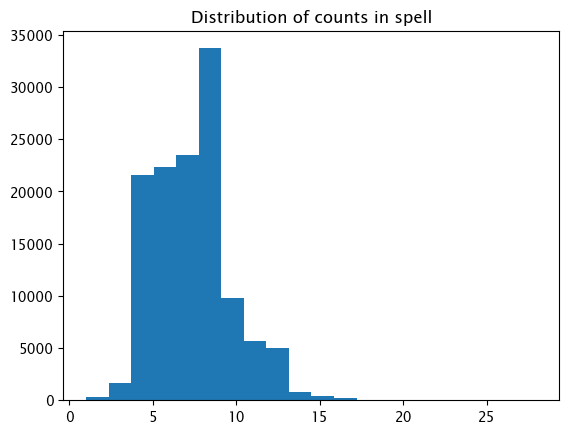

In [334]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

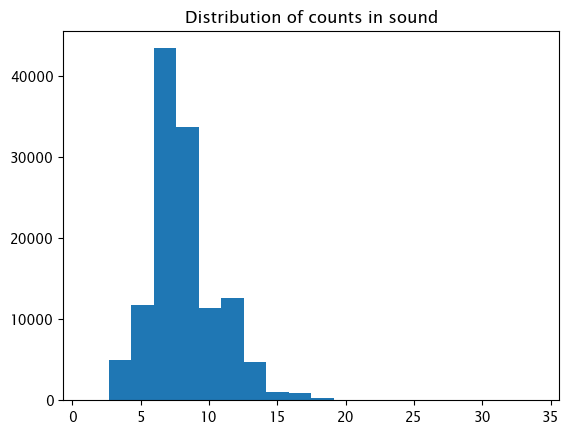

In [335]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

In [336]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size   = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 4997 (0.040) rows by discarding 119919 rows


# build terms, part 1

In [337]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 5 chars
discarding pairs whose sn_size part has more than 11 chars
975 (0.195) pairs were removed
4022 pairs remain


In [338]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [339]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
32284,"[#, d, r, a, w, b, a, c, k, #]","[#, ˈ, d, ɹ, ɔ, ˌ, b, æ, k, #]"
47551,"[#, g, u, l, y, a, s, #]","[#, ˈ, ɡ, u, ɫ, j, ə, s, #]"
104673,"[#, s, l, o, w, e, s, t, #]","[#, ˈ, s, ɫ, o, ʊ, ə, s, t, #]"
84008,"[#, p, a, s, t, e, r, n, a, c, k, #]","[#, ˈ, p, æ, s, t, ɝ, n, æ, k, #]"
13723,"[#, b, r, a, t, #]","[#, ˈ, b, ɹ, æ, t, #]"
...,...,...
102461,"[#, s, h, e, p, h, e, r, d, i, n, g, #]","[#, ˈ, ʃ, ɛ, p, ɝ, d, ɪ, ŋ, #]"
109973,"[#, s, u, n, n, y, v, a, l, e, #]","[#, ˈ, s, ə, n, i, ˌ, v, e, ɪ, ɫ, #]"
87910,"[#, p, o, p, o, f, f, #]","[#, ˈ, p, ɑ, ˌ, p, ɔ, f, #]"
80268,"[#, o, b, n, o, x, i, o, u, s, #]","[#, ɑ, b, ˈ, n, ɑ, k, ʃ, ə, s, #]"


In [340]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 8044),
 ('e', 3136),
 ('a', 2388),
 ('r', 2179),
 ('s', 2158),
 ('n', 1914),
 ('i', 1874),
 ('o', 1766),
 ('l', 1694),
 ('t', 1495)]

In [341]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 8044),
 ('ˈ', 4056),
 ('ɪ', 1890),
 ('ə', 1853),
 ('n', 1550),
 ('ɫ', 1441),
 ('s', 1428),
 ('t', 1392),
 ('ɹ', 1250),
 ('k', 1198)]

In [342]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [343]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [344]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    pool = mp.Pool (processes = max(os.cpu_count() - 1, 1))
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [345]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [346]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#d, dr, ra, aw, wb, ba, ac, ck, k#, #, d, r, ...
47551     [#g, gu, ul, ly, ya, as, s#, #, g, u, l, y, a,...
104673    [#s, sl, lo, ow, we, es, st, t#, #, s, l, o, w...
84008     [#p, pa, as, st, te, er, rn, na, ac, ck, k#, #...
13723                [#b, br, ra, at, t#, #, b, r, a, t, #]
                                ...                        
102461    [#s, sh, he, ep, ph, he, er, rd, di, in, ng, g...
109973    [#s, su, un, nn, ny, yv, va, al, le, e#, #, s,...
87910     [#p, po, op, po, of, ff, f#, #, p, o, p, o, f,...
80268     [#o, ob, bn, no, ox, xi, io, ou, us, s#, #, o,...
43288     [#g, ga, as, sp, pe, er, r#, #, g, a, s, p, e,...
Name: sp_2gram, Length: 4022, dtype: object


In [347]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#dr, dra, raw, awb, wba, bac, ack, ck#, #d, d...
47551     [#gu, gul, uly, lya, yas, as#, #g, gu, ul, ly,...
104673    [#sl, slo, low, owe, wes, est, st#, #s, sl, lo...
84008     [#pa, pas, ast, ste, ter, ern, rna, nac, ack, ...
13723              [#br, bra, rat, at#, #b, br, ra, at, t#]
                                ...                        
102461    [#sh, she, hep, eph, phe, her, erd, rdi, din, ...
109973    [#su, sun, unn, nny, nyv, yva, val, ale, le#, ...
87910     [#po, pop, opo, pof, off, ff#, #p, po, op, po,...
80268     [#ob, obn, bno, nox, oxi, xio, iou, ous, us#, ...
43288     [#ga, gas, asp, spe, per, er#, #g, ga, as, sp,...
Name: sp_3gram, Length: 4022, dtype: object


In [348]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#dra, draw, rawb, awba, wbac, back, ack#, #dr...
47551     [#gul, guly, ulya, lyas, yas#, #gu, gul, uly, ...
104673    [#slo, slow, lowe, owes, west, est#, #sl, slo,...
84008     [#pas, past, aste, ster, tern, erna, rnac, nac...
13723                [#bra, brat, rat#, #br, bra, rat, at#]
                                ...                        
102461    [#she, shep, heph, ephe, pher, herd, erdi, rdi...
109973    [#sun, sunn, unny, nnyv, nyva, yval, vale, ale...
87910     [#pop, popo, opof, poff, off#, #po, pop, opo, ...
80268     [#obn, obno, bnox, noxi, oxio, xiou, ious, ous...
43288     [#gas, gasp, aspe, sper, per#, #ga, gas, asp, ...
Name: sp_4gram, Length: 4022, dtype: object


In [349]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [350]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#d, #…r, #…a, #…w, #…b, dr, d…a, d…w, d…b, ra...
47551     [#g, #…u, #…l, #…y, #…a, gu, g…l, g…y, g…a, ul...
104673    [#s, #…l, #…o, #…w, #…e, sl, s…o, s…w, s…e, lo...
84008     [#p, #…a, #…s, #…t, #…e, pa, p…s, p…t, p…e, as...
13723     [#b, #…r, #…a, #…t, #…#, br, b…a, b…t, b…#, ra...
                                ...                        
102461    [#s, #…h, #…e, #…p, #…h, sh, s…e, s…p, s…h, he...
109973    [#s, #…u, #…n, #…n, #…y, su, s…n, s…n, s…y, un...
87910     [#p, #…o, #…p, #…o, #…f, po, p…p, p…o, p…f, op...
80268     [#o, #…b, #…n, #…o, #…x, ob, o…n, o…o, o…x, bn...
43288     [#g, #…a, #…s, #…p, #…e, ga, g…s, g…p, g…e, as...
Name: sp_sk2gram, Length: 4022, dtype: object


In [351]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#dr, #d…a, #d…w, #d…b, #…ra, #…r…w, #…r…b, #…...
47551     [#gu, #g…l, #g…y, #g…a, #…ul, #…u…y, #…u…a, #…...
104673    [#sl, #s…o, #s…w, #s…e, #…lo, #…l…w, #…l…e, #…...
84008     [#pa, #p…s, #p…t, #p…e, #…as, #…a…t, #…a…e, #…...
13723     [#br, #b…a, #b…t, #b…#, #…ra, #…r…t, #…r…#, #…...
                                ...                        
102461    [#sh, #s…e, #s…p, #s…h, #…he, #…h…p, #…h…h, #…...
109973    [#su, #s…n, #s…n, #s…y, #…un, #…u…n, #…u…y, #…...
87910     [#po, #p…p, #p…o, #p…f, #…op, #…o…o, #…o…f, #…...
80268     [#ob, #o…n, #o…o, #o…x, #…bn, #…b…o, #…b…x, #…...
43288     [#ga, #g…s, #g…p, #g…e, #…as, #…a…p, #…a…e, #…...
Name: sp_sk3gram, Length: 4022, dtype: object


In [352]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#dra, #dr…w, #dr…b, #d…aw, #d…a…b, #d…wb, #…r...
47551     [#gul, #gu…y, #gu…a, #g…ly, #g…l…a, #g…ya, #…u...
104673    [#slo, #sl…w, #sl…e, #s…ow, #s…o…e, #s…we, #…l...
84008     [#pas, #pa…t, #pa…e, #p…st, #p…s…e, #p…te, #…a...
13723     [#bra, #br…t, #br…#, #b…at, #b…a…#, #b…t#, #…r...
                                ...                        
102461    [#she, #sh…p, #sh…h, #s…ep, #s…e…h, #s…ph, #…h...
109973    [#sun, #su…n, #su…y, #s…nn, #s…n…y, #s…ny, #…u...
87910     [#pop, #po…o, #po…f, #p…po, #p…p…f, #p…of, #…o...
80268     [#obn, #ob…o, #ob…x, #o…no, #o…n…x, #o…ox, #…b...
43288     [#gas, #ga…p, #ga…e, #g…sp, #g…s…e, #g…pe, #…a...
Name: sp_sk4gram, Length: 4022, dtype: object


In [353]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [354]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram
32284,#drawback#,"[#d, #…r, #…a, #…w, #…b, dr, d…a, d…w, d…b, ra...","[#dr, #d…a, #d…w, #d…b, #…ra, #…r…w, #…r…b, #…...","[#dra, #dr…w, #dr…b, #d…aw, #d…a…b, #d…wb, #…r..."
47551,#gulyas#,"[#g, #…u, #…l, #…y, #…a, gu, g…l, g…y, g…a, ul...","[#gu, #g…l, #g…y, #g…a, #…ul, #…u…y, #…u…a, #…...","[#gul, #gu…y, #gu…a, #g…ly, #g…l…a, #g…ya, #…u..."
104673,#slowest#,"[#s, #…l, #…o, #…w, #…e, sl, s…o, s…w, s…e, lo...","[#sl, #s…o, #s…w, #s…e, #…lo, #…l…w, #…l…e, #…...","[#slo, #sl…w, #sl…e, #s…ow, #s…o…e, #s…we, #…l..."
84008,#pasternack#,"[#p, #…a, #…s, #…t, #…e, pa, p…s, p…t, p…e, as...","[#pa, #p…s, #p…t, #p…e, #…as, #…a…t, #…a…e, #…...","[#pas, #pa…t, #pa…e, #p…st, #p…s…e, #p…te, #…a..."
13723,#brat#,"[#b, #…r, #…a, #…t, #…#, br, b…a, b…t, b…#, ra...","[#br, #b…a, #b…t, #b…#, #…ra, #…r…t, #…r…#, #…...","[#bra, #br…t, #br…#, #b…at, #b…a…#, #b…t#, #…r..."
...,...,...,...,...
102461,#shepherding#,"[#s, #…h, #…e, #…p, #…h, sh, s…e, s…p, s…h, he...","[#sh, #s…e, #s…p, #s…h, #…he, #…h…p, #…h…h, #…...","[#she, #sh…p, #sh…h, #s…ep, #s…e…h, #s…ph, #…h..."
109973,#sunnyvale#,"[#s, #…u, #…n, #…n, #…y, su, s…n, s…n, s…y, un...","[#su, #s…n, #s…n, #s…y, #…un, #…u…n, #…u…y, #…...","[#sun, #su…n, #su…y, #s…nn, #s…n…y, #s…ny, #…u..."
87910,#popoff#,"[#p, #…o, #…p, #…o, #…f, po, p…p, p…o, p…f, op...","[#po, #p…p, #p…o, #p…f, #…op, #…o…o, #…o…f, #…...","[#pop, #po…o, #po…f, #p…po, #p…p…f, #p…of, #…o..."
80268,#obnoxious#,"[#o, #…b, #…n, #…o, #…x, ob, o…n, o…o, o…x, bn...","[#ob, #o…n, #o…o, #o…x, #…bn, #…b…o, #…b…x, #…...","[#obn, #ob…o, #ob…x, #o…no, #o…n…x, #o…ox, #…b..."


# Sound n-grams 生成

In [355]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈ, ˈd, dɹ, ɹɔ, ɔˌ, ˌb, bæ, æk, k#, #, ˈ, d, ...
47551     [#ˈ, ˈɡ, ɡu, uɫ, ɫj, jə, əs, s#, #, ˈ, ɡ, u, ɫ...
104673    [#ˈ, ˈs, sɫ, ɫo, oʊ, ʊə, əs, st, t#, #, ˈ, s, ...
84008     [#ˈ, ˈp, pæ, æs, st, tɝ, ɝn, næ, æk, k#, #, ˈ,...
13723         [#ˈ, ˈb, bɹ, ɹæ, æt, t#, #, ˈ, b, ɹ, æ, t, #]
                                ...                        
102461    [#ˈ, ˈʃ, ʃɛ, ɛp, pɝ, ɝd, dɪ, ɪŋ, ŋ#, #, ˈ, ʃ, ...
109973    [#ˈ, ˈs, sə, ən, ni, iˌ, ˌv, ve, eɪ, ɪɫ, ɫ#, #...
87910     [#ˈ, ˈp, pɑ, ɑˌ, ˌp, pɔ, ɔf, f#, #, ˈ, p, ɑ, ˌ...
80268     [#ɑ, ɑb, bˈ, ˈn, nɑ, ɑk, kʃ, ʃə, əs, s#, #, ɑ,...
43288     [#ˈ, ˈɡ, ɡæ, æs, sp, pɝ, ɝ#, #, ˈ, ɡ, æ, s, p,...
Name: sn_2gram, Length: 4022, dtype: object


In [356]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈd, ˈdɹ, dɹɔ, ɹɔˌ, ɔˌb, ˌbæ, bæk, æk#, #ˈ, ˈ...
47551     [#ˈɡ, ˈɡu, ɡuɫ, uɫj, ɫjə, jəs, əs#, #ˈ, ˈɡ, ɡu...
104673    [#ˈs, ˈsɫ, sɫo, ɫoʊ, oʊə, ʊəs, əst, st#, #ˈ, ˈ...
84008     [#ˈp, ˈpæ, pæs, æst, stɝ, tɝn, ɝnæ, næk, æk#, ...
13723     [#ˈb, ˈbɹ, bɹæ, ɹæt, æt#, #ˈ, ˈb, bɹ, ɹæ, æt, t#]
                                ...                        
102461    [#ˈʃ, ˈʃɛ, ʃɛp, ɛpɝ, pɝd, ɝdɪ, dɪŋ, ɪŋ#, #ˈ, ˈ...
109973    [#ˈs, ˈsə, sən, əni, niˌ, iˌv, ˌve, veɪ, eɪɫ, ...
87910     [#ˈp, ˈpɑ, pɑˌ, ɑˌp, ˌpɔ, pɔf, ɔf#, #ˈ, ˈp, pɑ...
80268     [#ɑb, ɑbˈ, bˈn, ˈnɑ, nɑk, ɑkʃ, kʃə, ʃəs, əs#, ...
43288     [#ˈɡ, ˈɡæ, ɡæs, æsp, spɝ, pɝ#, #ˈ, ˈɡ, ɡæ, æs,...
Name: sn_3gram, Length: 4022, dtype: object


In [357]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈdɹ, ˈdɹɔ, dɹɔˌ, ɹɔˌb, ɔˌbæ, ˌbæk, bæk#, #ˈd...
47551     [#ˈɡu, ˈɡuɫ, ɡuɫj, uɫjə, ɫjəs, jəs#, #ˈɡ, ˈɡu,...
104673    [#ˈsɫ, ˈsɫo, sɫoʊ, ɫoʊə, oʊəs, ʊəst, əst#, #ˈs...
84008     [#ˈpæ, ˈpæs, pæst, æstɝ, stɝn, tɝnæ, ɝnæk, næk...
13723     [#ˈbɹ, ˈbɹæ, bɹæt, ɹæt#, #ˈb, ˈbɹ, bɹæ, ɹæt, æt#]
                                ...                        
102461    [#ˈʃɛ, ˈʃɛp, ʃɛpɝ, ɛpɝd, pɝdɪ, ɝdɪŋ, dɪŋ#, #ˈʃ...
109973    [#ˈsə, ˈsən, səni, əniˌ, niˌv, iˌve, ˌveɪ, veɪ...
87910     [#ˈpɑ, ˈpɑˌ, pɑˌp, ɑˌpɔ, ˌpɔf, pɔf#, #ˈp, ˈpɑ,...
80268     [#ɑbˈ, ɑbˈn, bˈnɑ, ˈnɑk, nɑkʃ, ɑkʃə, kʃəs, ʃəs...
43288     [#ˈɡæ, ˈɡæs, ɡæsp, æspɝ, spɝ#, #ˈɡ, ˈɡæ, ɡæs, ...
Name: sn_4gram, Length: 4022, dtype: object


In [358]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈdɹɔ, ˈdɹɔˌ, dɹɔˌb, ɹɔˌbæ, ɔˌbæk, ˌbæk#, #ˈd...
47551     [#ˈɡuɫ, ˈɡuɫj, ɡuɫjə, uɫjəs, ɫjəs#, #ˈɡu, ˈɡuɫ...
104673    [#ˈsɫo, ˈsɫoʊ, sɫoʊə, ɫoʊəs, oʊəst, ʊəst#, #ˈs...
84008     [#ˈpæs, ˈpæst, pæstɝ, æstɝn, stɝnæ, tɝnæk, ɝnæ...
13723         [#ˈbɹæ, ˈbɹæt, bɹæt#, #ˈbɹ, ˈbɹæ, bɹæt, ɹæt#]
                                ...                        
102461    [#ˈʃɛp, ˈʃɛpɝ, ʃɛpɝd, ɛpɝdɪ, pɝdɪŋ, ɝdɪŋ#, #ˈʃ...
109973    [#ˈsən, ˈsəni, səniˌ, əniˌv, niˌve, iˌveɪ, ˌve...
87910     [#ˈpɑˌ, ˈpɑˌp, pɑˌpɔ, ɑˌpɔf, ˌpɔf#, #ˈpɑ, ˈpɑˌ...
80268     [#ɑbˈn, ɑbˈnɑ, bˈnɑk, ˈnɑkʃ, nɑkʃə, ɑkʃəs, kʃə...
43288     [#ˈɡæs, ˈɡæsp, ɡæspɝ, æspɝ#, #ˈɡæ, ˈɡæs, ɡæsp,...
Name: sn_5gram, Length: 4022, dtype: object


In [359]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈ, #…d, #…ɹ, #…ɔ, #…ˌ, ˈd, ˈ…ɹ, ˈ…ɔ, ˈ…ˌ, dɹ...
47551     [#ˈ, #…ɡ, #…u, #…ɫ, #…j, ˈɡ, ˈ…u, ˈ…ɫ, ˈ…j, ɡu...
104673    [#ˈ, #…s, #…ɫ, #…o, #…ʊ, ˈs, ˈ…ɫ, ˈ…o, ˈ…ʊ, sɫ...
84008     [#ˈ, #…p, #…æ, #…s, #…t, ˈp, ˈ…æ, ˈ…s, ˈ…t, pæ...
13723     [#ˈ, #…b, #…ɹ, #…æ, #…t, ˈb, ˈ…ɹ, ˈ…æ, ˈ…t, bɹ...
                                ...                        
102461    [#ˈ, #…ʃ, #…ɛ, #…p, #…ɝ, ˈʃ, ˈ…ɛ, ˈ…p, ˈ…ɝ, ʃɛ...
109973    [#ˈ, #…s, #…ə, #…n, #…i, ˈs, ˈ…ə, ˈ…n, ˈ…i, sə...
87910     [#ˈ, #…p, #…ɑ, #…ˌ, #…p, ˈp, ˈ…ɑ, ˈ…ˌ, ˈ…p, pɑ...
80268     [#ɑ, #…b, #…ˈ, #…n, #…ɑ, ɑb, ɑ…ˈ, ɑ…n, ɑ…ɑ, bˈ...
43288     [#ˈ, #…ɡ, #…æ, #…s, #…p, ˈɡ, ˈ…æ, ˈ…s, ˈ…p, ɡæ...
Name: sn_sk2gram, Length: 4022, dtype: object


In [360]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈd, #ˈ…ɹ, #ˈ…ɔ, #ˈ…ˌ, #…dɹ, #…d…ɔ, #…d…ˌ, #…...
47551     [#ˈɡ, #ˈ…u, #ˈ…ɫ, #ˈ…j, #…ɡu, #…ɡ…ɫ, #…ɡ…j, #…...
104673    [#ˈs, #ˈ…ɫ, #ˈ…o, #ˈ…ʊ, #…sɫ, #…s…o, #…s…ʊ, #…...
84008     [#ˈp, #ˈ…æ, #ˈ…s, #ˈ…t, #…pæ, #…p…s, #…p…t, #…...
13723     [#ˈb, #ˈ…ɹ, #ˈ…æ, #ˈ…t, #…bɹ, #…b…æ, #…b…t, #…...
                                ...                        
102461    [#ˈʃ, #ˈ…ɛ, #ˈ…p, #ˈ…ɝ, #…ʃɛ, #…ʃ…p, #…ʃ…ɝ, #…...
109973    [#ˈs, #ˈ…ə, #ˈ…n, #ˈ…i, #…sə, #…s…n, #…s…i, #…...
87910     [#ˈp, #ˈ…ɑ, #ˈ…ˌ, #ˈ…p, #…pɑ, #…p…ˌ, #…p…p, #…...
80268     [#ɑb, #ɑ…ˈ, #ɑ…n, #ɑ…ɑ, #…bˈ, #…b…n, #…b…ɑ, #…...
43288     [#ˈɡ, #ˈ…æ, #ˈ…s, #ˈ…p, #…ɡæ, #…ɡ…s, #…ɡ…p, #…...
Name: sn_sk3gram, Length: 4022, dtype: object


In [361]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈdɹ, #ˈd…ɔ, #ˈd…ˌ, #ˈ…ɹɔ, #ˈ…ɹ…ˌ, #ˈ…ɔˌ, #…d...
47551     [#ˈɡu, #ˈɡ…ɫ, #ˈɡ…j, #ˈ…uɫ, #ˈ…u…j, #ˈ…ɫj, #…ɡ...
104673    [#ˈsɫ, #ˈs…o, #ˈs…ʊ, #ˈ…ɫo, #ˈ…ɫ…ʊ, #ˈ…oʊ, #…s...
84008     [#ˈpæ, #ˈp…s, #ˈp…t, #ˈ…æs, #ˈ…æ…t, #ˈ…st, #…p...
13723     [#ˈbɹ, #ˈb…æ, #ˈb…t, #ˈ…ɹæ, #ˈ…ɹ…t, #ˈ…æt, #…b...
                                ...                        
102461    [#ˈʃɛ, #ˈʃ…p, #ˈʃ…ɝ, #ˈ…ɛp, #ˈ…ɛ…ɝ, #ˈ…pɝ, #…ʃ...
109973    [#ˈsə, #ˈs…n, #ˈs…i, #ˈ…ən, #ˈ…ə…i, #ˈ…ni, #…s...
87910     [#ˈpɑ, #ˈp…ˌ, #ˈp…p, #ˈ…ɑˌ, #ˈ…ɑ…p, #ˈ…ˌp, #…p...
80268     [#ɑbˈ, #ɑb…n, #ɑb…ɑ, #ɑ…ˈn, #ɑ…ˈ…ɑ, #ɑ…nɑ, #…b...
43288     [#ˈɡæ, #ˈɡ…s, #ˈɡ…p, #ˈ…æs, #ˈ…æ…p, #ˈ…sp, #…ɡ...
Name: sn_sk4gram, Length: 4022, dtype: object


In [362]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

32284     [#ˈdɹɔ, #ˈdɹ…ˌ, #ˈd…ɔˌ, #ˈ…ɹɔˌ, #…dɹɔˌ, ˈdɹɔˌ,...
47551     [#ˈɡuɫ, #ˈɡu…j, #ˈɡ…ɫj, #ˈ…uɫj, #…ɡuɫj, ˈɡuɫj,...
104673    [#ˈsɫo, #ˈsɫ…ʊ, #ˈs…oʊ, #ˈ…ɫoʊ, #…sɫoʊ, ˈsɫoʊ,...
84008     [#ˈpæs, #ˈpæ…t, #ˈp…st, #ˈ…æst, #…pæst, ˈpæst,...
13723     [#ˈbɹæ, #ˈbɹ…t, #ˈb…æt, #ˈ…ɹæt, #…bɹæt, ˈbɹæt,...
                                ...                        
102461    [#ˈʃɛp, #ˈʃɛ…ɝ, #ˈʃ…pɝ, #ˈ…ɛpɝ, #…ʃɛpɝ, ˈʃɛpɝ,...
109973    [#ˈsən, #ˈsə…i, #ˈs…ni, #ˈ…əni, #…səni, ˈsəni,...
87910     [#ˈpɑˌ, #ˈpɑ…p, #ˈp…ˌp, #ˈ…ɑˌp, #…pɑˌp, ˈpɑˌp,...
80268     [#ɑbˈn, #ɑbˈ…ɑ, #ɑb…nɑ, #ɑ…ˈnɑ, #…bˈnɑ, ɑbˈnɑ,...
43288     [#ˈɡæs, #ˈɡæ…p, #ˈɡ…sp, #ˈ…æsp, #…ɡæsp, ˈɡæsp,...
Name: sn_sk5gram, Length: 4022, dtype: object


In [363]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram,sn_sk5gram
32284,#ˈdɹɔˌbæk#,"[#ˈ, #…d, #…ɹ, #…ɔ, #…ˌ, ˈd, ˈ…ɹ, ˈ…ɔ, ˈ…ˌ, dɹ...","[#ˈd, #ˈ…ɹ, #ˈ…ɔ, #ˈ…ˌ, #…dɹ, #…d…ɔ, #…d…ˌ, #…...","[#ˈdɹ, #ˈd…ɔ, #ˈd…ˌ, #ˈ…ɹɔ, #ˈ…ɹ…ˌ, #ˈ…ɔˌ, #…d...","[#ˈdɹɔ, #ˈdɹ…ˌ, #ˈd…ɔˌ, #ˈ…ɹɔˌ, #…dɹɔˌ, ˈdɹɔˌ,..."
47551,#ˈɡuɫjəs#,"[#ˈ, #…ɡ, #…u, #…ɫ, #…j, ˈɡ, ˈ…u, ˈ…ɫ, ˈ…j, ɡu...","[#ˈɡ, #ˈ…u, #ˈ…ɫ, #ˈ…j, #…ɡu, #…ɡ…ɫ, #…ɡ…j, #…...","[#ˈɡu, #ˈɡ…ɫ, #ˈɡ…j, #ˈ…uɫ, #ˈ…u…j, #ˈ…ɫj, #…ɡ...","[#ˈɡuɫ, #ˈɡu…j, #ˈɡ…ɫj, #ˈ…uɫj, #…ɡuɫj, ˈɡuɫj,..."
104673,#ˈsɫoʊəst#,"[#ˈ, #…s, #…ɫ, #…o, #…ʊ, ˈs, ˈ…ɫ, ˈ…o, ˈ…ʊ, sɫ...","[#ˈs, #ˈ…ɫ, #ˈ…o, #ˈ…ʊ, #…sɫ, #…s…o, #…s…ʊ, #…...","[#ˈsɫ, #ˈs…o, #ˈs…ʊ, #ˈ…ɫo, #ˈ…ɫ…ʊ, #ˈ…oʊ, #…s...","[#ˈsɫo, #ˈsɫ…ʊ, #ˈs…oʊ, #ˈ…ɫoʊ, #…sɫoʊ, ˈsɫoʊ,..."
84008,#ˈpæstɝnæk#,"[#ˈ, #…p, #…æ, #…s, #…t, ˈp, ˈ…æ, ˈ…s, ˈ…t, pæ...","[#ˈp, #ˈ…æ, #ˈ…s, #ˈ…t, #…pæ, #…p…s, #…p…t, #…...","[#ˈpæ, #ˈp…s, #ˈp…t, #ˈ…æs, #ˈ…æ…t, #ˈ…st, #…p...","[#ˈpæs, #ˈpæ…t, #ˈp…st, #ˈ…æst, #…pæst, ˈpæst,..."
13723,#ˈbɹæt#,"[#ˈ, #…b, #…ɹ, #…æ, #…t, ˈb, ˈ…ɹ, ˈ…æ, ˈ…t, bɹ...","[#ˈb, #ˈ…ɹ, #ˈ…æ, #ˈ…t, #…bɹ, #…b…æ, #…b…t, #…...","[#ˈbɹ, #ˈb…æ, #ˈb…t, #ˈ…ɹæ, #ˈ…ɹ…t, #ˈ…æt, #…b...","[#ˈbɹæ, #ˈbɹ…t, #ˈb…æt, #ˈ…ɹæt, #…bɹæt, ˈbɹæt,..."
...,...,...,...,...,...
102461,#ˈʃɛpɝdɪŋ#,"[#ˈ, #…ʃ, #…ɛ, #…p, #…ɝ, ˈʃ, ˈ…ɛ, ˈ…p, ˈ…ɝ, ʃɛ...","[#ˈʃ, #ˈ…ɛ, #ˈ…p, #ˈ…ɝ, #…ʃɛ, #…ʃ…p, #…ʃ…ɝ, #…...","[#ˈʃɛ, #ˈʃ…p, #ˈʃ…ɝ, #ˈ…ɛp, #ˈ…ɛ…ɝ, #ˈ…pɝ, #…ʃ...","[#ˈʃɛp, #ˈʃɛ…ɝ, #ˈʃ…pɝ, #ˈ…ɛpɝ, #…ʃɛpɝ, ˈʃɛpɝ,..."
109973,#ˈsəniˌveɪɫ#,"[#ˈ, #…s, #…ə, #…n, #…i, ˈs, ˈ…ə, ˈ…n, ˈ…i, sə...","[#ˈs, #ˈ…ə, #ˈ…n, #ˈ…i, #…sə, #…s…n, #…s…i, #…...","[#ˈsə, #ˈs…n, #ˈs…i, #ˈ…ən, #ˈ…ə…i, #ˈ…ni, #…s...","[#ˈsən, #ˈsə…i, #ˈs…ni, #ˈ…əni, #…səni, ˈsəni,..."
87910,#ˈpɑˌpɔf#,"[#ˈ, #…p, #…ɑ, #…ˌ, #…p, ˈp, ˈ…ɑ, ˈ…ˌ, ˈ…p, pɑ...","[#ˈp, #ˈ…ɑ, #ˈ…ˌ, #ˈ…p, #…pɑ, #…p…ˌ, #…p…p, #…...","[#ˈpɑ, #ˈp…ˌ, #ˈp…p, #ˈ…ɑˌ, #ˈ…ɑ…p, #ˈ…ˌp, #…p...","[#ˈpɑˌ, #ˈpɑ…p, #ˈp…ˌp, #ˈ…ɑˌp, #…pɑˌp, ˈpɑˌp,..."
80268,#ɑbˈnɑkʃəs#,"[#ɑ, #…b, #…ˈ, #…n, #…ɑ, ɑb, ɑ…ˈ, ɑ…n, ɑ…ɑ, bˈ...","[#ɑb, #ɑ…ˈ, #ɑ…n, #ɑ…ɑ, #…bˈ, #…b…n, #…b…ɑ, #…...","[#ɑbˈ, #ɑb…n, #ɑb…ɑ, #ɑ…ˈn, #ɑ…ˈ…ɑ, #ɑ…nɑ, #…b...","[#ɑbˈn, #ɑbˈ…ɑ, #ɑb…nɑ, #ɑ…ˈnɑ, #…bˈnɑ, ɑbˈnɑ,..."


# Pair = sp term :: sn term の生成

In [364]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_mark}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [365]:
## random sampling
import random
random.sample(random.sample(paired_terms, 1)[0], 20)

['#dig :: ɛst#',
 'dig :: ɛst#',
 'igr :: ɡɹɛst',
 'dig :: aɪˈɡ',
 '#dig :: daɪˈ',
 'gre :: daɪˈ',
 '#dig :: ɹɛst',
 'gres :: daɪˈ',
 'dig :: daɪˈɡ',
 'sed# :: ˈɡɹɛ',
 'igre :: aɪˈɡ',
 'igre :: #daɪˈ',
 '#di :: aɪˈɡ',
 'ess :: ɪˈɡɹɛ',
 'ed# :: ɛst#',
 'digr :: ɪˈɡɹ',
 'sed :: ɡɹɛst',
 'ssed :: aɪˈɡɹ',
 'igre :: ɡɹɛs',
 'ress :: ˈɡɹɛ']

In [366]:
## number of sentences
print(len(paired_terms))

4022


In [367]:
## total number of units
sum(map(len, paired_terms))

637794

In [368]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
term_type = "paired_term"
df[ ['sp_word', 'sn_word', term_type ] ]

,sp_word,sn_word,paired_term
32284,#drawback#,#ˈdɹɔˌbæk#,"[#dra :: #ˈdɹɔ, #dra :: ˈdɹɔˌ, #dra :: dɹɔˌb, ..."
47551,#gulyas#,#ˈɡuɫjəs#,"[#gul :: #ˈɡuɫ, #gul :: ˈɡuɫj, #gul :: ɡuɫjə, ..."
104673,#slowest#,#ˈsɫoʊəst#,"[#slo :: #ˈsɫo, #slo :: ˈsɫoʊ, #slo :: sɫoʊə, ..."
84008,#pasternack#,#ˈpæstɝnæk#,"[#pas :: #ˈpæs, #pas :: ˈpæst, #pas :: pæstɝ, ..."
13723,#brat#,#ˈbɹæt#,"[#bra :: #ˈbɹæ, #bra :: ˈbɹæt, #bra :: bɹæt#, ..."
...,...,...,...
102461,#shepherding#,#ˈʃɛpɝdɪŋ#,"[#she :: #ˈʃɛp, #she :: ˈʃɛpɝ, #she :: ʃɛpɝd, ..."
109973,#sunnyvale#,#ˈsəniˌveɪɫ#,"[#sun :: #ˈsən, #sun :: ˈsəni, #sun :: səniˌ, ..."
87910,#popoff#,#ˈpɑˌpɔf#,"[#pop :: #ˈpɑˌ, #pop :: ˈpɑˌp, #pop :: pɑˌpɔ, ..."
80268,#obnoxious#,#ɑbˈnɑkʃəs#,"[#obn :: #ɑbˈn, #obn :: ɑbˈnɑ, #obn :: bˈnɑk, ..."


In [369]:
## select data type and define doc_dict
import random
#doc_dict = { i: x for i, x in enumerate(df['paired_term']) }
sn_dict = { i: x for i, x in enumerate(df['sn_word']) }
sp_dict = { i: x for i, x in enumerate(df['sp_word']) }
## check
#random.sample(list(doc_dict.items()), 3)
#random.sample(list(sn_dict.items()), 5)
random.sample(list(zip(sp_dict.values(), sn_dict.values())), 10)

[("#fung's#", '#ˈfəŋz#'),
 ('#inda#', '#ˈində#'),
 ('#spratt#', '#ˈspɹæt#'),
 ('#asleep#', '#əˈsɫip#'),
 ("#walters'#", '#ˈwɔɫtɝz#'),
 ('#dayhuff#', '#ˈdeɪˌhəf#'),
 ('#hemmings#', '#ˈhɛmɪŋz#'),
 ('#discarding#', '#dɪˈskɑɹdɪŋ#'),
 ('#plunk#', '#ˈpɫəŋk#'),
 ('#bleacher#', '#ˈbɫitʃɝ#')]

# LDA/HDP の実行

In [370]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df[term_type]
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<576393 unique tokens: ['#dr :: #ˈdɹ', '#dr :: #ˈdɹɔ', '#dr :: bæk#', '#dr :: dɹɔˌ', '#dr :: dɹɔˌb']...>


In [371]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 2
abuse filter: 0.01
term filtering applied
Dictionary<37271 unique tokens: ['#dr :: #ˈdɹ', '#dr :: #ˈdɹɔ', '#dr :: ˈdɹɔ', '#dra :: #ˈdɹ', '#dra :: #ˈdɹɔ']...>


In [372]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 4022
106 empty docs are removed out from pair_corpus


In [373]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 100


# pyLDAvis の実行

In [374]:
##!conda install pyLDAvis
#!pip install pyLDAvis
#!conda update conda -y

In [375]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [376]:
## save LDAvis output as a html file
save_LDAvis = save_LDAvis
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [377]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [378]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 33


In [379]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
#method = "HDP" if use_HDP else "LDA"
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from {method_name} (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [380]:
## stop if HDP is used
if use_HDP:
    #sys.exit(0)
    pass

# Topic structure inspection

In [381]:
## derive LDA from HDP
pair_lda = pair_hdp.suggested_lda_model()

In [382]:
## topic investigation
import HDP_helper

target_hdp = pair_hdp
documents_topics = np.zeros([target_hdp.m_T, len(pair_corpus)])
for doc_id, c in enumerate(pair_corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        #doc = doc_dict[doc_id]
        sp = sp_dict[doc_id]
        sn = sn_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {sp} :: {sn}")

topic_id 0: 0.0 * heed :: ɑkˌhi + 0.0 * ran :: #ˈɡɹæ + 0.0 * ckh :: ˌhid + 0.0 * #lo :: ɫɑkˌ + 0.0 * lock :: #ˈɫɑ + 0.0 * ockh :: kˌhid + 0.0 * #loc :: ɫɑkˌ + 0.0 * man :: kmən + 0.0 * #loc :: kˌhi + 0.0 * khee :: ɫɑkˌ + 0.0 * loc :: ɫɑkˌ + 0.0 * eed :: kˌhid + 0.0 * eed :: ɫɑkˌh + 0.0 * #lo :: kˌhid + 0.0 * an# :: kmən# + 0.0 * ckh :: ˈɫɑk + 0.0 * ckhe :: kˌhi + 0.0 * heed :: ɑkˌh + 0.0 * loc :: ˈɫɑk + 0.0 * lock :: ˈɫɑk + 0.0 * loc :: ɑkˌh + 0.0 * ckhe :: kˌhid + 0.0 * #lo :: ɫɑkˌh + 0.0 * ockh :: ɑkˌhi + 0.0 * cie :: ɪəti + 0.0 * ckhe :: ˈɫɑkˌ + 0.0 * #lo :: ˌhid + 0.0 * heed :: ˈɫɑk + 0.0 * khe :: kˌhid + 0.0 * loc :: #ˈɫɑ + 0.0 * khe :: ˌhid + 0.0 * ock :: ˈɫɑkˌ + 0.0 * #lo :: ɑkˌh + 0.0 * ckh :: ˈɫɑkˌ + 0.0 * kman :: mən# + 0.0 * ock :: kˌhid + 0.0 * hee :: ɫɑkˌh + 0.0 * hee :: ˈɫɑkˌ + 0.0 * ock :: #ˈɫɑk + 0.0 * loc :: ɑkˌhi + 0.0 * ckhe :: ɑkˌh + 0.0 * ckhe :: #ˈɫɑ + 0.0 * ock :: kˌhi + 0.0 * ckh :: ɑkˌhi + 0.0 * ock :: #ˈɫɑ + 0.0 * #gr :: ˈɡɹæ + 0.0 * hee :: #ˈɫɑk + 0.0 * ckh :

In [383]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_lda.show_topics(topic, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,...,topic 91,topic 92,topic 93,topic 94,topic 95,topic 96,topic 97,topic 98,topic 99,topic 100
0,#bra :: #ˈbɹ,#dr :: ˈdɹɔ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,...,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ,#bra :: #ˈbɹ
1,past :: ˈpæs,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,...,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs,past :: ˈpæs
2,#br :: ˈbɹæt,NaN,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ,draw :: #ˈdɹɔ,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,...,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt,#br :: ˈbɹæt
3,ter :: æstɝ,NaN,NaN,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ,draw :: #ˈdɹɔ,back :: ˌbæk,ter :: æstɝ,ter :: æstɝ,...,ter :: æstɝ,#br :: ˈbɹæ,ter :: æstɝ,ter :: æstɝ,ter :: æstɝ,ter :: æstɝ,ter :: æstɝ,ter :: æstɝ,ter :: æstɝ,#br :: ˈbɹæ
4,#br :: bɹæt,NaN,NaN,NaN,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ,draw :: #ˈdɹɔ,back :: ˌbæk,raw :: #ˈdɹɔ,...,#br :: ˈbɹæ,ter :: æstɝ,#br :: ˈbɹæ,#br :: ˈbɹæ,#br :: ˈbɹæ,#br :: bɹæt,#br :: bɹæt,#br :: ˈbɹæ,#br :: ˈbɹæ,ter :: æstɝ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,raw :: #ˈdɹɔ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ,draw :: #ˈdɹɔ,back :: ˌbæk
96,back :: ˌbæk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ,draw :: #ˈdɹɔ
97,draw :: #ˈdɹɔ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#dr :: ˈdɹɔ,#dr :: #ˈdɹɔ
98,#dr :: #ˈdɹɔ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#dr :: ˈdɹɔ


In [385]:
if reload_modules:
    import importlib
    importlib.reload (HDP_helper)

4241 rows remain after density filtering, discarding 33030 rows
4241 rows remain after size filtering, discarding 0 rows
212 rows remain after size filtering, discarding 4029 rows


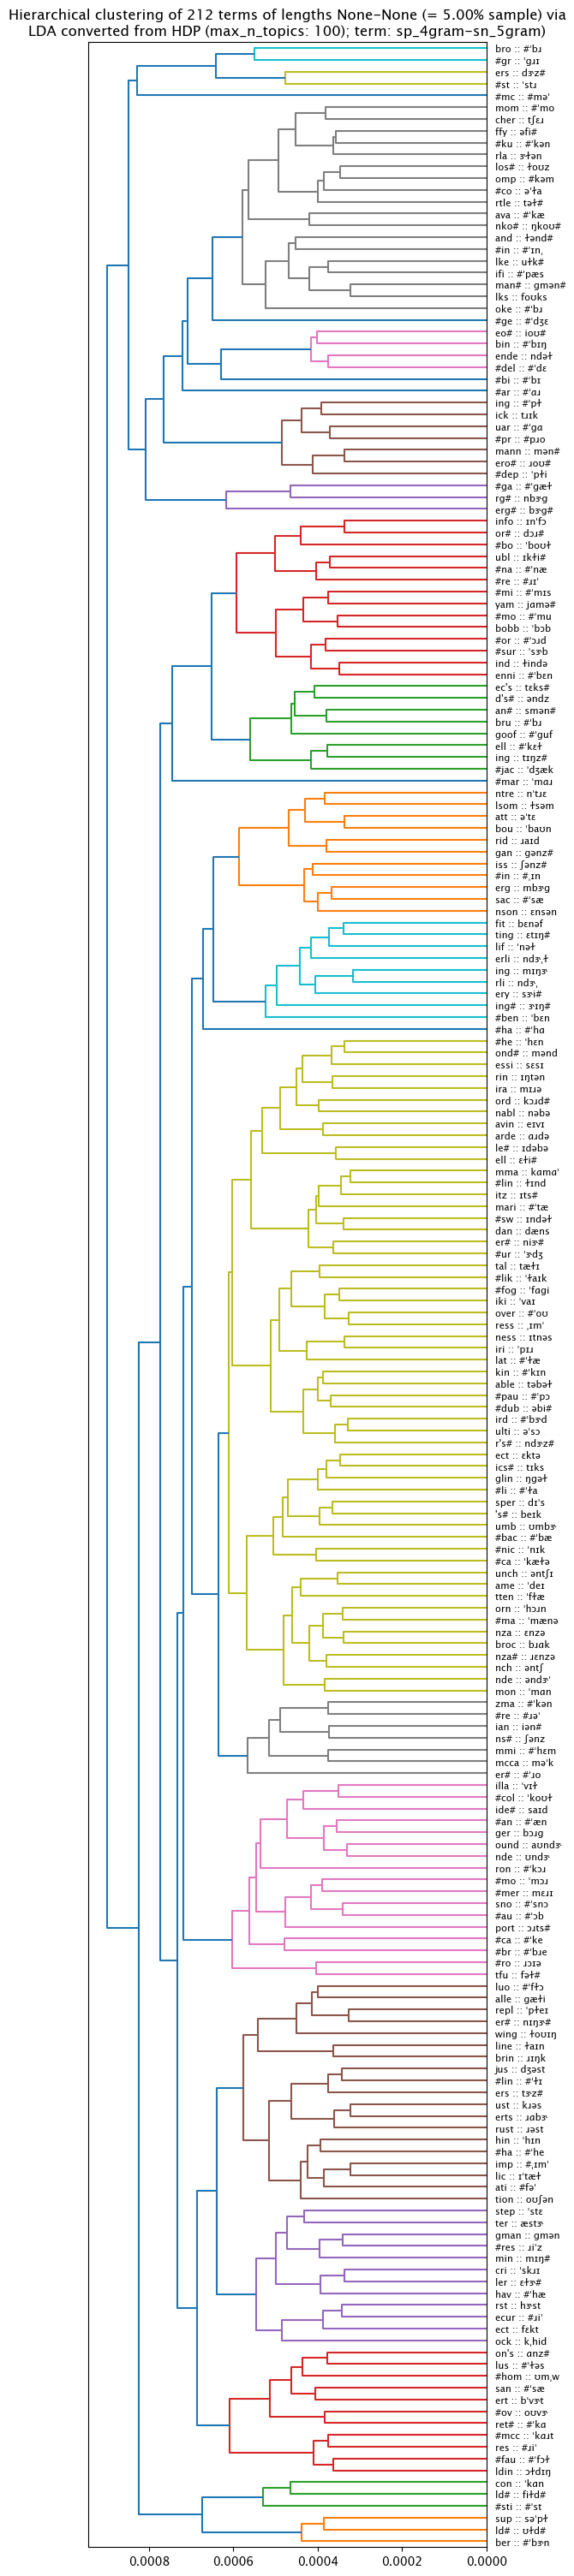

In [389]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (pair_hdp, pair_diction, term_type = term_type, n_topics= max_n_topics, lowest_density = 0.003, sampling_rate = 0.05, gap_mark = gap_mark, use_CJK = False, check = False)

In [396]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"results/terms-by-topics-raw/{lang_name}/{lang_key}-terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
print(f"targeting a file: {output_file}")
save_results = save_topic_structure
save_results = True
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)

targeting a file: results/terms-by-topics-raw/English/en-terms-by-topics-sp_4gram-sn_5gram-a=0.01-2024-10-26-16-28.csv
saving a file: results/terms-by-topics-raw/English/en-terms-by-topics-sp_4gram-sn_5gram-a=0.01-2024-10-26-16-28.csv
